In [1]:

import argparse
import os
import torch
import numpy as np
import random
import wandb
import models
import yaml
from trainer import Trainer
import pprint
from torchvision import transforms
import datasets

device = torch.device('cuda')

np.random.seed(0)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True


def get_dataset(dataset, noise_rate, noise_type):
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if dataset == "noisy_cifar10":
        train = datasets.NoisyCIFAR10("./data", download=True, transform=transform_train, noise_rate=noise_rate, noise_type=noise_type)
        test = datasets.CIFAR10("./data", download=True, train=False, transform=transform_test)
    elif dataset == "noisy_cifar100":
        train = datasets.NoisyCIFAR100("./data", download=True, transform=transform_train, noise_rate=noise_rate, noise_type=noise_type)
        test = datasets.CIFAR100("./data", download=True, train=False, transform=transform_test)
    else:
        raise NotImplementedError
    return train, test



In [18]:
# # Load YAML config
# with open("./configs/train_base.yml", 'r') as file:
#     config = yaml.safe_load(file)

# read YAML file from string
config = yaml.safe_load("""
data:
  dataset: noisy_cifar10
  noise_rate: 0.4
  noise_type: symmetric

model:
  architecture: resnet18
  num_classes: 10

wandb:
  mode: disabled # "disabled" or "online"
  entity: siit-iitp
  project: noisy-label

trainer:
  optimizer: sgd
  init_lr: 1.0e-1
  momentum: 0.9
  weight_decay: 1.0e-4
  lr_scheduler: multistep
  max_epoch: 200
  loss_fn: cross_entropy
  # loss_fn: mae
  num_classes: 10
  num_workers: 2
  batch_size: 512
  save_model: true
""")

pprint.pprint(config)

model = models.get_model(**config["model"]).to(device)


# NoisyCIFAR10(symm,0.4)-CE: mquy2drg
# NoisyCIFAR10(symm,0.4)-MAE: ccnf390c
checkpoint = wandb.restore("model_199.pth", run_path="siit-iitp/noisy-label/mquy2drg", replace=True)
model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))

trainer = Trainer(
                model=model,
                config=config['trainer'],
                )

# result = trainer.filter_noisy(train_dataset)

print(trainer.criterion)

{'data': {'dataset': 'noisy_cifar10',
          'noise_rate': 0.4,
          'noise_type': 'symmetric'},
 'model': {'architecture': 'resnet18', 'num_classes': 10},
 'trainer': {'batch_size': 512,
             'init_lr': 0.1,
             'loss_fn': 'cross_entropy',
             'lr_scheduler': 'multistep',
             'max_epoch': 200,
             'momentum': 0.9,
             'num_classes': 10,
             'num_workers': 2,
             'optimizer': 'sgd',
             'save_model': True,
             'weight_decay': 0.0001},
 'wandb': {'entity': 'siit-iitp', 'mode': 'disabled', 'project': 'noisy-label'}}
CrossEntropyLoss()


In [12]:
from models import MCDropout, GaussianMCDropout

# dropout = MCDropout
dropout = GaussianMCDropout

trainer.model.register_module("dropout", dropout())
def forward(self, x):
    x = self.get_feature(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
setattr(trainer.model, 'forward', forward.__get__(trainer.model, trainer.model.__class__))

In [13]:
# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset = datasets.NoisyCIFAR10("./data", download=True, transform=transform_train, noise_rate=config["data"]["noise_rate"], noise_type=config['data']['noise_type'])


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].to(device), batch["target"].to(device)
        target_gt = batch["target_gt"].to(device)
        losses = []
        for _ in range(10):
            data_ = transform_normalize(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

Files already downloaded and verified
{'is_noisy': tensor([ True, False, False,  ..., False,  True,  True]),
 'mean': tensor([2.5855, 4.4073, 2.9007,  ..., 3.2154, 3.6485, 5.0223]),
 'std': tensor([1.2025, 1.3695, 2.1315,  ..., 1.3767, 1.9617, 2.9859])}


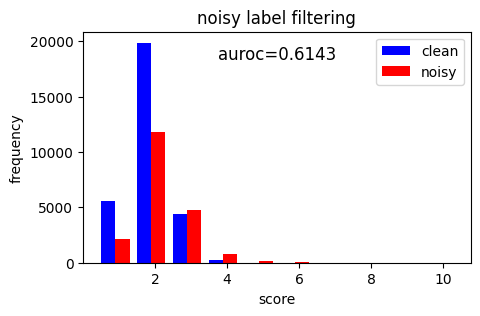

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
score = result['std']

is_noisy = result['is_noisy']

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')

ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])
# plt.hist(blue_data, bins=np.arange(0, 8, 0.5), color='blue', alpha=0.5, label="clean")
# plt.hist(red_data, bins=np.arange(0, 8, 0.5), color='red', alpha=0.5, label="noisy")

# add title and axis labels
ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")


# add legend
ax.legend()

# display the histogram
plt.show()


## use both MC dropout and input perturbation

In [25]:
from models import MCDropout, GaussianMCDropout

dropout = MCDropout
# dropout = GaussianMCDropout

trainer.model.register_module("dropout", dropout())
def forward(self, x):
    x = self.get_feature(x)
    x = self.dropout(x)
    x = self.fc(x)
    return x
setattr(trainer.model, 'forward', forward.__get__(trainer.model, trainer.model.__class__))




# loss magnitude-based filtering
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import torchvision.transforms.functional as F


transform_train = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.tensor(np.array(x)).permute(2,0,1))
])

transform_normalize = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_tta = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.Lambda(lambda x: x/255.0),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
# ])


train_dataset = datasets.NoisyCIFAR10("./data", download=True, transform=transform_train, noise_rate=config["data"]["noise_rate"], noise_type=config['data']['noise_type'])


with torch.no_grad():
    trainer.model.eval()
    dataloader = trainer.get_dataloader(train_dataset, train=False)

    result = {
        'std': [],
        'mean': [],
        'is_noisy': [],
    }
    for batch in dataloader:
        data, target = batch["image"].to(device), batch["target"].to(device)
        target_gt = batch["target_gt"].to(device)
        losses = []
        for _ in range(10):
            # data_ = torch.normal(transform_normalize(data), 0.1)
            data_ = transform_tta(data)
            output = trainer.model(data_)
            loss = trainer.criterion(output, target)
            losses.append(loss)
        std, mean = torch.std_mean(torch.stack(losses, dim=-1), dim=-1)
        is_noisy = (target != target_gt)
        result['std'].append(std)
        result['mean'].append(mean)
        result['is_noisy'].append(is_noisy)

    result['std'] = torch.cat(result['std'], dim=0).cpu()
    result['mean'] = torch.cat(result['mean'], dim=0).cpu()
    result['is_noisy'] = torch.cat(result['is_noisy'], dim=0).cpu()

pprint.pprint(result)

Files already downloaded and verified
{'is_noisy': tensor([ True, False, False,  ..., False,  True,  True]),
 'mean': tensor([4.2603, 1.4634, 1.9430,  ..., 1.4155, 8.1463, 3.7931]),
 'std': tensor([4.7797, 3.1380, 4.4100,  ..., 3.6128, 7.7957, 5.4224])}


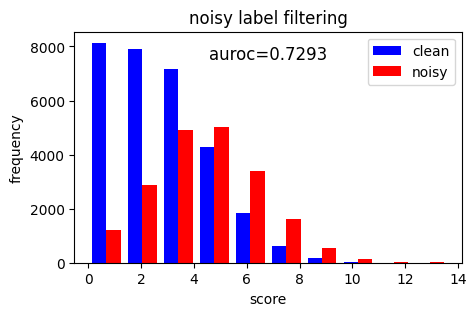

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# score = result['mean']
# score = result['mean'] + 0.5*result['std']
# score = result['mean'] - 0.5*result['std']
score = result['std']

is_noisy = result['is_noisy']

auroc = roc_auc_score(is_noisy, score)

blue_data = score[~is_noisy]
red_data = score[is_noisy]

fig, ax = plt.subplots(figsize=(5,3))
ax.text(0.5, 0.9,f"{auroc=:0.4f}",transform=ax.transAxes, fontsize=12, horizontalalignment='center', verticalalignment='center')

ax.hist([blue_data, red_data], color=['blue', 'red'], label=["clean", "noisy"])
# plt.hist(blue_data, bins=np.arange(0, 8, 0.5), color='blue', alpha=0.5, label="clean")
# plt.hist(red_data, bins=np.arange(0, 8, 0.5), color='red', alpha=0.5, label="noisy")

# add title and axis labels
ax.set_title("noisy label filtering")
ax.set_xlabel("score")
ax.set_ylabel("frequency")


# add legend
ax.legend()

# display the histogram
plt.show()
